In [1]:
%config IPCompleter.greedy=True
from IPython.display import IFrame

import pandas as pd
import numpy as np
import string
import math

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
from sklearn import discriminant_analysis as disan
from sklearn import calibration as calib
from sklearn import linear_model as lm
from sklearn import svm
from sklearn import gaussian_process as gaup
from sklearn import mixture as mix
from sklearn import tree
from sklearn import ensemble as ens


import sklearn.feature_selection as feature_selection

import pickle

#### Plotting Helper functions

In [2]:
def plot_bar_diagram(ax, data, nested=False, plots_labels=None, plots_colors=None, bar_labels='', width=0.4, title='', length_label='',
                     orient='v', legend_loc=None, spines=None):
    """
    Plots single or multiple bar diagrams with data labels on top(aside) of the bars
    :param ax: matplotlib axes
    :param data: pandas DataFrame where rows correspond to bar plots and columns correspond to data labels (columns in data)
    :param nested: boolean. If True, bar plots are plotted on top of each other. If False bar plots are plotted besides each other
    :param bar_labels: pandas DataFrame. labels over the bars. Should be same shape as data
    :param width: float. Bar width
    :param title: string. Plot title
    :param length_label: bar height/width axis label
    :param spines: dictionary of booleans. indicates to plot borders or not. Keys=['left', 'right', 'top', 'bottom'], values=True/False
    :param orient: string. Bar orientation: 'v'-vertical; 'h'-horisontal
    """
    bars = list(data.index)
    cols = list(data.columns)
    cells = data.values.tolist()

    if bar_labels is not None:
        for i, lab in enumerate(bars):
            labels = ([f"{j:.4f}" for j in cells[i]] if bar_labels=='' else bar_labels[i])

    if orient == 'v':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            color = ('r' if plots_colors is None else plots_colors[i])
            x = np.arange(len(cols))
            bar = ax.bar(x=x + width * (i - len(bars) / 2), height=cells[i], width=width,
                         label=label,
                         color=color,
                         align=('center' if nested else 'edge'))
            if bar_labels is not None:
                autolabel(bar, ax, labels, oriented='v')

        ax.set_xticks(np.arange(len(cols)))
        ax.set_xticklabels(cols)
        if not length_label=='':
            ax.set_ylabel(length_label)
    elif orient == 'h':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            y = np.arange(len(cols))
            height = width
            bar = ax.barh(y=y + height * (i - len(bars) / 2), width=cells[i], height=width,
                          label=label,
                          color=plots_colors[i],
                          align=('center' if nested else 'edge'))
            if bar_labels is not None:
                autolabel(bar, ax, labels, oriented='h')

        ax.set_yticks(np.arange(len(cols)))
        ax.set_yticklabels(cols)
        if not length_label=='':
            ax.set_xlabel(length_label)
    else:
        raise ValueError('orient parameter value error. expected v or h ')

    if not title == '':
        ttl = ax.title
        ttl.set_position([.5, 1.07])
        ax.set_title(title)
    if legend_loc is not None:
        ax.legend(loc=legend_loc)
    else:
        ax.legend().set_visible(False)

    if spines is None:
        spines = {'left': True,
                  'right': True,
                  'top': True,
                  'bottom': True}
    for i in list(spines.keys()):
        ax.spines[i].set_visible(spines[i])

def autolabel(bars, ax, labels, oriented='v'):
    """Attach a text label displaying its height/width (depends of orientation)."""
    for bar, label in zip(bars, labels):
        if oriented == 'v':
            height = bar.get_height()
            ax.annotate(label,
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 2),
                        textcoords="offset points",
                        ha='center')
        else:
            width = bar.get_width()
            ax.annotate(label,
                        xy=(width, bar.get_y() + bar.get_height() / 2),
                        xytext=(1, 0),
                        textcoords="offset points",
                        ha='left',
                        va='center')

def plot_correlation_matrix(ax, data, cmap='hot', diagonal=False, square=True):
    mask = None
    if diagonal:
        mask = np.zeros_like(data, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    sns.heatmap(data, ax=ax,
                mask=mask,
                square=square,
                linewidths=1.5,
                cmap=cmap,
                cbar_kws={'shrink': 1, 'ticks': [-1, -.5, 0, 0.5, 1]},
                vmin=-1,
                vmax=1,
                annot=True,
                annot_kws={'size': 8})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    
def plot_confusion_matrix(model, X, y, ax, normalize=True, title=None):
    """Plots confusion matrix
    Parameters:
    ax =  matplotlib axes
    normalyze = normalization over truth (number_predicted / total_count_of_this_class)
    """
    model.fit(X,y)
    conf_matrix = metrics.confusion_matrix(y_true=y, y_pred=model.predict(X),
                              labels=None)  # returns matrix for sorted classes (i.e 0, 1, 2,..., n)
    classes = y.unique()
    classes.sort()
    n_classes = [len(y[y == c]) for c in classes]
    if normalize == True:
        n_matrix = [[i for j in range(len(n_classes))] for i in n_classes]
        norm_matrix = conf_matrix / np.array(n_classes)
        ns_matrix = np.array([[i for j in enumerate(n_classes)] for i in n_classes])
        labels = np.array([["{0:.2%} \n {1:d} of {2:d}".format(norm_matrix[i, j], conf_matrix[i, j],
                                                               ns_matrix[i, j]) for j, v in
                            enumerate(norm_matrix[i])]
                           for i, v in enumerate(norm_matrix)])

        sns.heatmap(norm_matrix, annot=labels, fmt='', cmap='Blues')
    else:
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

    ax.set_ylabel('True Labels')
    ax.set_xlabel('Predicted Labels')
    if title is None:
        title = model.__class__.__name__
    ax.set_title(title)
    ttl = ax.title
    ttl.set_position([.5, 1.07])

    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = ax.get_ylim()  # discover the values for bottom and top
    b += 0.5  # Add 0.5 to the bottom
    t -= 0.5  # Subtract 0.5 from the top
    ax.set_ylim(b, t)  # update the ylim(bottom, top) values

#### Helper functions for model training

In [3]:
# Tune parameters
def param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=''):
    if refit == '': refit = list(scoring.keys())[0]
    gsearch = model_selection.GridSearchCV(estimator=model, param_grid=param_ranges, scoring=scoring, cv=cv, refit=refit, return_train_score=True,
                           n_jobs=-1)
    gsearch.fit(X_train, y_train)
    cv_res = pd.DataFrame(gsearch.cv_results_)
    cv_res_sel = []
    for i in list(scoring.keys()):
        df = cv_res.loc[cv_res['rank_test_%s' % i] == 1].head(1)
        cv_res_sel.append(df[['mean_train_%s' % i, 'std_train_%s' % i, 'mean_test_%s' % i, 'std_test_%s' % i]].values[0])

    cv_res_sel = pd.DataFrame(cv_res_sel, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_res_sel.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return gsearch.best_estimator_, gsearch.best_params_, gsearch.best_score_, cv_results

# Cross-validation report
def cv_rep(model, X, y, cv, scoring):
    cv_res = model_selection.cross_validate(model, X, y, scoring=scoring, cv=cv, return_train_score=True, n_jobs=-1)
    cv_res = [[np.mean(cv_res['train_%s' % i]), np.std(cv_res['train_%s' % i]), np.mean(cv_res['test_%s' % i]), np.std(cv_res['test_%s' % i])] for i in list(scoring.keys())]
    cv_results = pd.DataFrame(cv_res, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_results.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return cv_results

# Tune model parameters and print CV report
def train_best_model(model, param_ranges, X_train, y_train, scoring, cv, refit):
    model, best_params, best_score, cv_res = param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print(cv_res)
    print(best_params)
    return model, cv_res

# Tune model parameters and print CV report for calibrated classifier model
def train_best_model_cal(model, param_ranges, X_train, y_train, scoring, cv, refit):
    if model.__class__.__name__=='CalibratedClassifierCV':
         model_cal= model 
    else:
        model_cal = calib.CalibratedClassifierCV(base_estimator=model, method='sigmoid', cv=cv)
    model_cal, best_params, best_score, cv_res = param_tune(model_cal, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print(cv_res)
    print(best_params)
    return model, cv_res

### Import data

In [4]:
#import train dataset
filename_tr = 'train.csv'
data_train = pd.read_csv(filename_tr)

#import test dataset
filename_tes = 'test.csv'
data_test = pd.read_csv(filename_tes)

#### Training Set

In [5]:
data_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Test Set

In [6]:
data_test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


#### Checking missing values in training set

In [7]:
nulls = data_train.isnull().sum()
nulls = nulls.loc[nulls > 0]
nulls = nulls.to_frame(name='count')
N = len(data_train.index)
nulls.insert(1, 'percent', ['{0:.2%}'.format(nulls.loc['Age'][0] / N), 
                            '{0:.2%}'.format(nulls.loc['Cabin'][0] / N),
                            '{0:.2%}'.format(nulls.loc['Embarked'][0] / N)])
nulls

,count,percent
Age,177,19.87%
Cabin,687,77.10%
Embarked,2,0.22%


Seems to be a lot of missing values in 'Age' and 'Cabin'.

As I concluded from preliminary analysis, the Age is one of the critical and must be treated first.

The Cabin and Embarked are probably not important in Survival prediction.

I will come to nulls later but for now lets look on distributions.

#### Checking missing values in test set

In [8]:
nulls = data_test.isnull().sum()
nulls = nulls.loc[nulls > 0]
nulls = nulls.to_frame(name='count')
nulls

,count
Age,86
Fare,1
Cabin,327


There is one missing value for ticket fare. For now I will assign it a zero.

In [9]:
data_test = data_test.fillna(value={'Fare':0})

#### Calculate survival rate

In [10]:
#how many died
N_surv0 = len(data_train.loc[data_train['Survived']==0])
#how many survived
N_surv1 = len(data_train.loc[data_train['Survived']==1])

print('Deads: {0} ({1:.2%})'.format(N_surv0, N_surv0 / N))
print('Survivals: {0} ({1:.2%})'.format(N_surv1, N_surv1 / N))

Deads: 549 (61.62%)
Survivals: 342 (38.38%)


Well, only 1/3 survived. That was expectable though.

#### Replace 'Name' with encoded titles

In [11]:
#Concatinate train & test data (to make sure that all unique titles are captured)
data_tot = pd.concat([data_train, data_test], ignore_index=True)

In [12]:
#Encode 'Name'
def name_encoder(data):
    data_encoded = []
    for i in data['Name']:
        lname0 = i.split(',')[0].strip() #last name
        ttl = i.split(',')[1].split('.')[0].strip() #title
        lname1 = (i.split('(')[-1].split(')')[0].split()[-1].strip() if '(' in i else '').replace('\"','') #second last name
        data_encoded.append([lname0, lname1, ttl])
    data_encoded = pd.DataFrame(data_encoded, columns=['lname0', 'lname1', 'ttl'], index=data.index)
    return pd.concat([data.reset_index(drop=True), data_encoded], axis=1)

In [13]:
df_name = name_encoder(data_tot['Name'].to_frame())
df_name.head(5)

,Name,lname0,lname1,ttl
0,"Braund, Mr. Owen Harris",Braund,,Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Cumings,Thayer,Mrs
2,"Heikkinen, Miss. Laina",Heikkinen,,Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Futrelle,Peel,Mrs
4,"Allen, Mr. William Henry",Allen,,Mr


In [14]:
#Find unique titles and their counts
ttl = df_name['ttl'].unique()
ttl = pd.DataFrame([[i, len(df_name.loc[df_name['ttl']==i])] for i in ttl], columns=['ttl', 'ttl_n'])
ttl.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
ttl,Mr,Mrs,Miss,Master,Don,Rev,Dr,Mme,Ms,Major,Lady,Sir,Mlle,Col,Capt,the Countess,Jonkheer,Dona
ttl_n,757,197,260,61,1,8,8,1,2,2,1,1,2,4,1,1,1,1


In [15]:
#Explore samples with 'Dr' title
df_name.loc[df_name['ttl']=='Dr']

,Name,lname0,lname1,ttl
245,"Minahan, Dr. William Edward",Minahan,,Dr
317,"Moraweck, Dr. Ernest",Moraweck,,Dr
398,"Pain, Dr. Alfred",Pain,,Dr
632,"Stahelin-Maeglin, Dr. Max",Stahelin-Maeglin,,Dr
660,"Frauenthal, Dr. Henry William",Frauenthal,,Dr
766,"Brewe, Dr. Arthur Jackson",Brewe,,Dr
796,"Leader, Dr. Alice (Farnham)",Leader,Farnham,Dr
1184,"Dodge, Dr. Washington",Dodge,,Dr


_**Leader, Dr. Alice (Farnham) is only one woman with title 'Dr'._

The function below will replace each person's name with encoded title. Instead of using all unique titles, I will teke only these: 'Mr', 'Mrs', 'Miss' and 'Master'.

In [16]:
def title_encoder(data):
    mask = {'Don':'Mr',
            'Sir':'Mr',
            'Jonkheer':'Mr',
            'Mme':'Mrs',
            'Lady':'Mrs',
            'the Countess':'Mrs',
            'Dona':'Mrs',
            'Mlle':'Miss',
            'Ms':'Miss',
            'Major':'Mr',
            'Col':'Mr',
            'Capt':'Mr',
            'Rev':'Mr',
            'Dr':'Mr'}
    
    data = name_encoder(data)
    data['ttl'] = data['ttl'].apply(lambda i: mask[i] if i in mask else i)
    if 797 in data['PassengerId'].values:
        data.loc[data_tot['PassengerId']==797, 'ttl'] = 'Mrs'
    mask = {'Mr':1, 'Mrs':2, 'Miss':3, 'Master':4}
    data['ttl'] = data['ttl'].apply(lambda i: mask[i])
    return data

#### Explore missing values for 'Embarked'

In [17]:
data_tot.loc[data_tot['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Display samples with similar ticket number

In [126]:
df = data_tot.query('Ticket.str.contains("1135")')
df.sort_values(by='Ticket')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
782,783,0.0,1,"Long, Mr. Milton Clyde",male,29.0,0,0,113501,30.0000,D6,S
377,378,0.0,1,"Widener, Mr. Harry Elkins",male,27.0,0,2,113503,211.5000,C82,C
965,966,NaN,1,"Geiger, Miss. Amalie",female,35.0,0,0,113503,211.5000,C130,C
966,967,NaN,1,"Keeping, Mr. Edwin",male,32.5,0,0,113503,211.5000,C132,C
1109,1110,NaN,1,"Widener, Mrs. George Dunton (Eleanor Elkins)",female,50.0,1,1,113503,211.5000,C80,C
1298,1299,NaN,1,"Widener, Mr. George Dunton",male,50.0,1,1,113503,211.5000,C80,C
166,167,1.0,1,"Chibnall, Mrs. (Edith Martha Bowerman)",female,NaN,0,1,113505,55.0000,E33,S
356,357,1.0,1,"Bowerman, Miss. Elsie Edith",female,22.0,0,1,113505,55.0000,E33,S
54,55,0.0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,C
917,918,NaN,1,"Ostby, Miss. Helene Ragnhild",female,22.0,0,1,113509,61.9792,B36,C


All people with similar ticket numbers are embarked in 'C' or 'S'. So i will simply assign the most frequent class to both missed values.

In [19]:
nc = len(df.loc[df['Embarked']=='C'])
ns = len(df.loc[df['Embarked']=='S'])
n = len(df.index)

print('C: %d' % nc)
print('S: %d' % ns)
print('All: %d' % n)

C: 7
S: 5
All: 14


The function below will be used to encode 'Embarked' variable

In [20]:
#Encoding 'Embarked'
def embarked_encoder(data):
    if len(data.loc[data['Embarked'].isnull()].index)>0:
        data = data.fillna(value={'Embarked':'C'})
    mask = {'C':0, 'S':1, 'Q':2}
    data['Embarked'] = data['Embarked'].apply(lambda i: mask[i])
    return data

### Grouping by ticket ID

While exploring the dataset, I found that many passengers have identical ticket numbers as well as identical fare value.

In this section, for all people with matching tickets, I will recalculate ticket fare for every i-th person in a group g as: fare(i, g) = fare(g) / n, where n is a number of people in group g.

In [21]:
# Clean text function
def clean_text(text):
    text = ''.join([c for c in text if c not in string.punctuation]).strip()
    text = ''.join(text.split())
    return text

In [22]:
# Clean ticket ID from all punctuation and spaces
df_fam = data_tot.copy()
df_fam['Ticket'] = df_fam['Ticket'].apply(lambda i: clean_text(i))

Numbers of unique and non-unique tickets:

In [23]:
print('Unique tickets: %d' % len(df_fam['Ticket'].unique()))
print('Non-unique tickets: %d' % (len(df_fam.index) - len(df_fam['Ticket'].unique())))

Unique tickets: 929
Non-unique tickets: 380


I want to define the following groups:
1. No family (SibSp==0 & Parch==0), unique tickets
2. No family (SibSp==0 & Parch==0), non-unique tickets
3. Has family, no children (SibSp >0 & Parch==0), unique tickets
4. Has family, no children (SibSp >0 & Parch==0), non-unique tickets
5. Has family, has children (Parch >0), unique tickets
6. Has family, has children (Parch >0), non-unique tickets

In [24]:
families0 = df_fam.loc[(df_fam['SibSp']>0) & (df_fam['Parch']==0)]
families1 = df_fam.loc[df_fam['Parch']>0]
singles = df_fam.loc[(df_fam['SibSp']==0) & (df_fam['Parch']==0)]

In [25]:
# This function is used to return sub-groups by unique and non-unique tickets from a group by SibSP and Parch
def grps_by_size(grp):
    #group size > 1
    grp1 = None
    #group size == 1
    grp0 = None
    for g in grp.groups:
        grp_ = grp.get_group(g)
        if len(grp.get_group(g).index)>1:
            if grp1 is None:
                grp1 = grp_
            else:
                grp1 = pd.concat([grp1, grp_])
        else:
            if grp0 is None:
                grp0 = grp_
            else:
                grp0 = pd.concat([grp0, grp_])
    return (grp0, grp1)

In [26]:
#singles
sig_grp = singles.groupby('Ticket')
#families NO children
fam0_grp = families0.groupby('Ticket')
#families w/children
fam1_grp = families1.groupby('Ticket')

#no family, unique ticket
sig0 = grps_by_size(sig_grp)[0]
#no family, matching tickets
sig1 = grps_by_size(sig_grp)[1]
#has family, no children, unique ticket
fam0 = grps_by_size(fam0_grp)[0]
#has family, no children, matching ticket
fam1 = grps_by_size(fam0_grp)[1]
#has family, has children, unique ticket
famch0 = grps_by_size(fam1_grp)[0]
#has family, has children, matching ticket
famch1 = grps_by_size(fam1_grp)[1]

print('Singles-----------------------')
print('Matching tickets groups: %d' % len(sig1.index))
print('Unique tickets groups: %d' % len(sig0.index))
print('------------------------------')

print('Families----------------------')
print('Matching tickets groups: %d' % len(fam1.index))
print('Unique tickets groups: %d' % len(fam0.index))
print('------------------------------')

print('Families W/children-----------')
print('Matching tickets groups: %d' % len(famch1.index))
print('Unique tickets groups: %d' % len(famch0.index))
print('------------------------------')

Singles-----------------------
Matching tickets groups: 108
Unique tickets groups: 682
------------------------------
Families----------------------
Matching tickets groups: 174
Unique tickets groups: 38
------------------------------
Families W/children-----------
Matching tickets groups: 288
Unique tickets groups: 19
------------------------------


In [27]:
# Family groups
fam_grps = [sig0, sig1, fam0, fam1, famch0, famch1]

In [28]:
# Make a mask of family groups labels
fgrp_mask = {}
for idx, grp in enumerate(fam_grps):
    for pid in grp['PassengerId']:
        fgrp_mask[pid] = idx

In [29]:
# Make a mask of ticket fare
fare_mask = {}
for tic in df_fam['Ticket'].unique():
    # subgroup with matching tickets
    tic_grp = df_fam.loc[df_fam['Ticket']==tic]
    
    # passenger class that the subgroup belongs to
    c = tic_grp['Pclass'].values[0]
    
    # ticket fare of the subgroup
    # all subgroup members have the same ticket fare initially
    fare_grp = tic_grp['Fare'].values[0]
    
    # if a subgroup fare is 0 then assign a mean of the fare of the Pclass that the subgroup belongs to
    if (fare_grp == 0) or (fare_grp is None):
        fare_i = np.mean(df_fam.loc[df_fam['Pclass']==c, 'Fare'])
        for pid in tic_grp['PassengerId']:
            fare_mask[pid] = fare_i

    # recalculate fare for subrgoup members: fare_i = group_fare / n_members
    if len(tic_grp.index) > 1:
        if fare_grp > 0:
            
            if np.mean(tic_grp['Fare'])==fare_grp: #check if all group members have same fare
                fare_i = fare_grp / len(tic_grp.index)
                for pid in tic_grp['PassengerId']:
                    fare_mask[pid] = fare_i
            else:
                for pid in tic_grp['PassengerId']:
                    fare_mask[pid] = tic_grp.loc[tic_grp['PassengerId']==pid, 'Fare'].values[0]
    # keep fare value for passengers with unuque tickets
    else:
        if fare_grp > 0:
            fare_i = fare_grp
            for pid in tic_grp['PassengerId']:
                fare_mask[pid] = fare_i

In [30]:
# Make a mask of ticket codes
m_tickets = []
for tic in df_fam['Ticket'].unique():
    if len(df_fam.loc[df_fam['Ticket']==tic].index) > 1:
        m_tickets.append(tic)

ticket_mask = {}        
for pid in df_fam['PassengerId']:
    tic = df_fam.loc[df_fam['PassengerId']==pid, 'Ticket'].values[0]
    if tic in m_tickets:
        ticket_mask[pid] = m_tickets.index(tic) + 1
    else:
        ticket_mask[pid] = 0

In [31]:
# Encode family groups
# This function adds new class variable 'fgrp' that indicates a group that a passenger belongs to.
def family_groups_encoder(data, fgrp_mask):
    data['fgrp'] = data['PassengerId'].apply(lambda i: fgrp_mask[i])
    return data

# Recalculate ticket fare in the family groups and fill missing values with a mean for corresponding passenger class.
def fare_encoder(data, fare_mask):
    data['Fare'] = data['PassengerId'].apply(lambda i: fare_mask[i])
    return data

# Encode tickets
def ticket_encoder(data, ticket_mask):
    data['Ticket'] = data['PassengerId'].apply(lambda i: ticket_mask[i])
    return data

### Transform numerical features

In [32]:
# Log-transform 'Fare'
def fare_transformer(data):
    data['Fare'] = data['Fare'].apply(np.log)
    return data

### Other variables encoding

In [33]:
# Encode 'Sex'
def sex_encoder(data):
    mask = {'male':0, 'female':1}
    df = data['Sex'].apply(lambda i: mask[i])
    return pd.concat([data.drop(columns=['Sex']), df], axis=1)

# Add 'Family size'
def fam_size(data):
    data['famsize'] = data['SibSp'] + data['Parch']
    data['famsize'] = data['famsize'].apply(lambda i: i if i<8 else 8)
    return data

#Encoding 'Pclass' (to labels 0,1,2)
def pclass_encoder(data):
    data['Pclass'] = data['Pclass'].apply(lambda i: i-1)
    return data

### Age prediction

I want to use 2-step approach to predict missing values for Age.

1. Use BayesianGaussianMixture to define clusters in the existing Age data and then train a classifier that will predict these cluster labels based on other features.
2. Train a regression model that will predict Age values based on existing features and Age class labels.

In [53]:
# Log-transform 'Age'
df_age = data_tot['Age'].dropna().copy().to_frame()
df_age['Age_trans'] = df_age['Age'].apply(np.log)

In [54]:
#Define clustering model
age_clast_model = mix.BayesianGaussianMixture(n_components=3, 
                                              covariance_type='spherical', 
                                              init_params='kmeans', 
                                              weight_concentration_prior_type='dirichlet_distribution', 
                                              max_iter=1000,
                                              random_state=30)

In [55]:
#Predict cluster labels
X = df_age['Age_trans'].to_frame()
df_age['Age_cls'] = age_clast_model.fit_predict(X)
df_age['Age_cls'] = df_age['Age_cls'].astype(int)

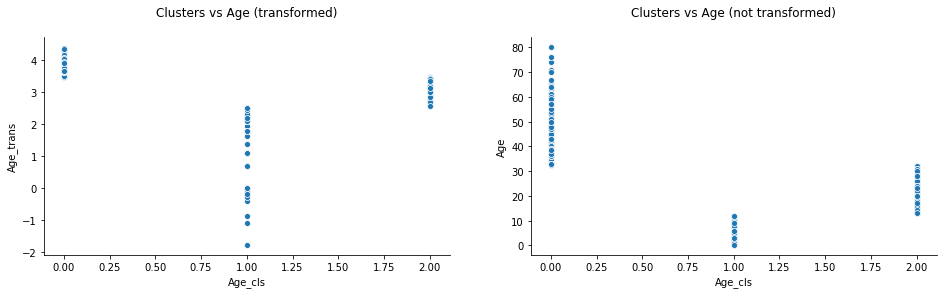

In [56]:
fig = plt.figure()
fig.set_size_inches(16,4)

fig.add_subplot(1,2,1)
ax = sns.scatterplot(x='Age_cls', y='Age_trans', data=df_age)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ttl = ax.title
ttl.set_position([.5, 1.07])
a=ax.set_title('Clusters vs Age (transformed)')

fig.add_subplot(1,2,2)
ax = sns.scatterplot(x='Age_cls', y='Age', data=df_age)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ttl = ax.title
ttl.set_position([.5, 1.07])
a=ax.set_title('Clusters vs Age (not transformed)')

#### Distributions within clasters (age - transformed)

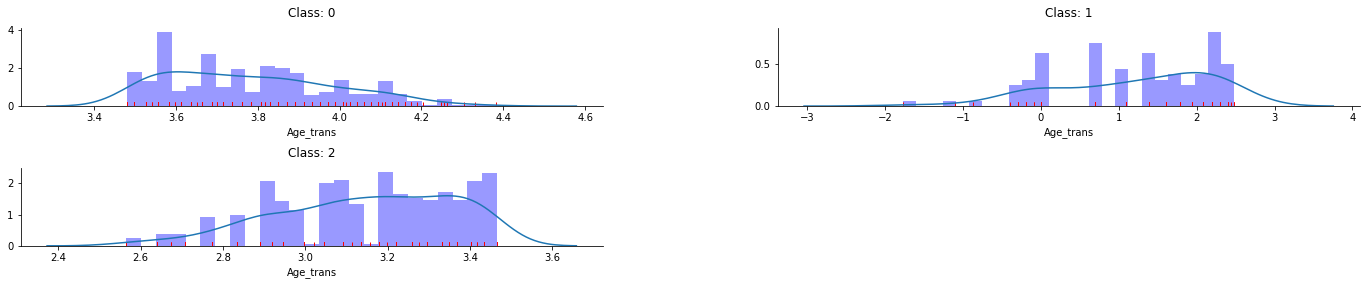

In [57]:
grd = sorted(df_age['Age_cls'].unique())
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 2
plt_w = 12


fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.8)

for idx, c in enumerate(grd):
    fig.add_subplot(gs[idx])
    df = df_age.loc[df_age['Age_cls']==c, 'Age_trans']
    ax = sns.distplot(df,
                 bins=25, kde=True, norm_hist=True, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "b"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Class: {0}'.format(c))

#### Distributions within clasters (age - not transformed)

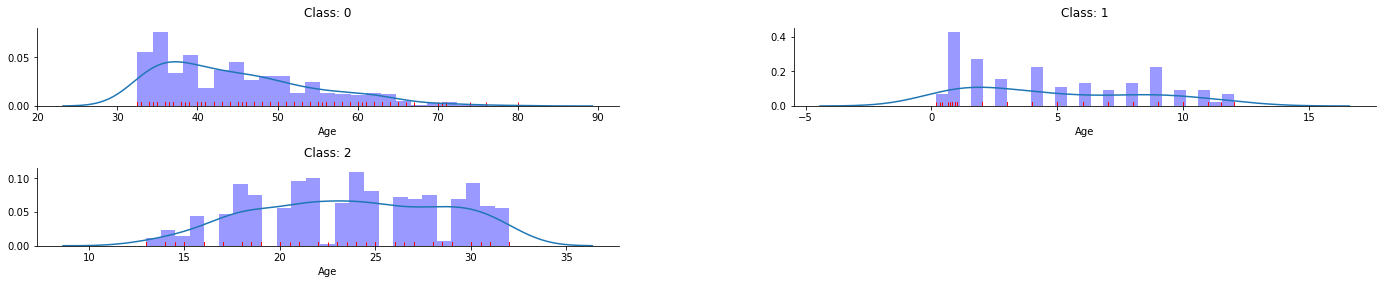

In [58]:
grd = sorted(df_age['Age_cls'].unique())
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 2
plt_w = 12


fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.8)

for idx, c in enumerate(grd):
    fig.add_subplot(gs[idx])
    df = df_age.loc[df_age['Age_cls']==c, 'Age']
    ax = sns.distplot(df,
                 bins=25, kde=True, norm_hist=True, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "b"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Class: {0}'.format(c))

In [59]:
def age_transformer(data, model):
    data['Age_trans'] = data['Age'].apply(np.log)
    X = data['Age_trans'].to_frame()
    data['Age_cls'] = model.predict(X)
    data['Age_cls'] = data['Age_cls'].astype(int)
    return data

### Predict missing missing values for age

In [60]:
data = family_groups_encoder(data_tot.copy(), fgrp_mask)
data = fare_encoder(data, fare_mask)
data = fare_transformer(data)

data = ticket_encoder(data, ticket_mask)

data = title_encoder(data)
data = sex_encoder(data)
data = fam_size(data)
data = embarked_encoder(data)
data = pclass_encoder(data)

data = data[data['Age'].notna()].copy()
data = age_transformer(data, age_clast_model)

data = data[['Age', 'Age_cls', 'Fare', 'Sex', 'ttl', 'fgrp', 'famsize', 'Ticket', 'Pclass', 'Embarked']]

#### Plot correlation matrix:

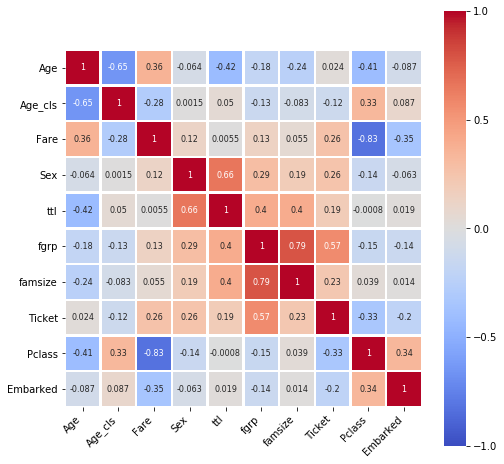

In [61]:
fig = plt.figure()
fig.set_size_inches(8, 8)
corr_matrix = data.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1), data=corr_matrix, cmap='coolwarm')

#### Train model for age class prediction

In [62]:
X = data.drop(columns=['Age', 'Age_cls'])
y = data['Age_cls']

In [63]:
X.columns

Index(['Fare', 'Sex', 'ttl', 'fgrp', 'famsize', 'Ticket', 'Pclass',
       'Embarked'],
      dtype='object')

In [64]:
def roc_auc_score_ovr(y_true, y_score):
    return metrics.roc_auc_score(y_true, y_score, average='macro', sample_weight=None, max_fpr=None,
                                 multi_class='ovr', labels=None)

def roc_auc_score_ovo(y_true, y_score):
    return metrics.roc_auc_score(y_true, y_score, average='macro', sample_weight=None, max_fpr=None,
                                 multi_class='ovo', labels=None)

In [65]:
#common random_state
random_state=30

#cross validation strategy
cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=random_state)

#cross validation metrics
scoring = {'balanced_accuracy': 'balanced_accuracy',
           'roc_auc_ovr':  metrics.make_scorer(roc_auc_score_ovr, needs_proba=True),
           'roc_auc_ovo':  metrics.make_scorer(roc_auc_score_ovo, needs_proba=True),
           'precision_macro': 'precision_macro'}
refit = 'roc_auc_ovr'

##### Initial model

In [66]:
params = {'learning_rate': 0.1, 
          'n_estimators': 25,
          'min_weight_fraction_leaf': 0.099, 
          'min_impurity_decrease': 0.05,
          'max_depth': 4,
          'subsample': 1.0,
          'ccp_alpha': 0.0}

age_cls_model = ens.GradientBoostingClassifier(loss='deviance', criterion='friedman_mse', 
                                               random_state=random_state, **params)
cv_rep(age_cls_model, X, y, cv, scoring)

,balanced_accuracy,roc_auc_ovr,roc_auc_ovo,precision_macro
mean_train,0.773038,0.872537,0.914197,0.755189
std_train,0.007318,0.005321,0.004704,0.012687
mean_test,0.731562,0.834598,0.887808,0.700383
std_test,0.019142,0.017756,0.014903,0.033610


##### Tune parameters

In [217]:
param_ranges = {'learning_rate': np.linspace(0.001, 2, 40), 'n_estimators': np.arange(5, 100, 20)}
age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy  roc_auc_ovr  roc_auc_ovo  precision_macro
mean_train           0.813961     0.895783     0.927829         0.800968
std_train            0.006383     0.002708     0.002401         0.011050
mean_test            0.741475     0.834445     0.891237         0.755926
std_test             0.024806     0.013762     0.012268         0.035005
{'learning_rate': 0.10351282051282051, 'n_estimators': 25}


In [218]:
param_ranges = {'min_weight_fraction_leaf': np.linspace(0.001, 0.2, 40), 'min_impurity_decrease': np.linspace(0.0001, 0.1, 40)}
age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy  roc_auc_ovr  roc_auc_ovo  precision_macro
mean_train           0.807140     0.873549     0.932800         0.858260
std_train            0.008867     0.004988     0.002136         0.005161
mean_test            0.737756     0.835782     0.890787         0.740880
std_test             0.020965     0.017971     0.013299         0.024067
{'min_impurity_decrease': 0.04620769230769231, 'min_weight_fraction_leaf': 0.09794871794871796}


In [219]:
param_ranges = {'subsample': np.linspace(0.1, 1.0, 50), 'max_depth': np.arange(3, 10)}
age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy  roc_auc_ovr  roc_auc_ovo  precision_macro
mean_train           0.770329     0.873549     0.914540         0.761902
std_train            0.010318     0.004988     0.003866         0.010393
mean_test            0.737462     0.835782     0.889384         0.727031
std_test             0.020546     0.017971     0.014007         0.031261
{'max_depth': 4, 'subsample': 1.0}


In [220]:
param_ranges = {'ccp_alpha': np.linspace(0.00001,0.0001, 99)}
age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy  roc_auc_ovr  roc_auc_ovo  precision_macro
mean_train           0.775099     0.873549     0.915076         0.762602
std_train            0.006184     0.004988     0.004249         0.012823
mean_test            0.732548     0.835782     0.888968         0.705425
std_test             0.023170     0.017971     0.015052         0.033243
{'ccp_alpha': 1e-05}


In [67]:
age_cls_model.fit(X,y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.05, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.099, n_estimators=25,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=30, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

#### Train model for age prediction

In [68]:
# train test split
X = data.drop(columns=['Age'])
y = data['Age']

In [69]:
X.columns

Index(['Age_cls', 'Fare', 'Sex', 'ttl', 'fgrp', 'famsize', 'Ticket', 'Pclass',
       'Embarked'],
      dtype='object')

In [70]:
#common random_state
random_state=30

#cross validation strategy
cv = model_selection.RepeatedKFold(n_splits=5, n_repeats=10, random_state=random_state)

#cross validation metrics
scoring = {'explained_variance':  'explained_variance', 'r2': 'r2'}
refit='r2'

##### Initial model

In [71]:
params = {'learning_rate': 0.1, 
          'n_estimators': 55,
          'min_weight_fraction_leaf': 0.001, 
          'min_impurity_decrease': 0.5,
          'max_depth': 3,
          'subsample': 1.0,
          'ccp_alpha': 0.001}

age_reg_mogel = ens.GradientBoostingRegressor(loss='ls', criterion='friedman_mse', random_state=random_state, **params)
cv_rep(age_reg_mogel, X, y, cv, scoring)

,explained_variance,r2
mean_train,0.830083,0.830083
std_train,0.004575,0.004575
mean_test,0.782566,0.781170
std_test,0.023180,0.023503


##### Tune parameters

In [226]:
param_ranges = {'learning_rate': np.linspace(0.01, 0.1, 40), 'n_estimators': np.arange(5, 100, 25)}
age_reg_mogel, scores = train_best_model(age_reg_mogel, param_ranges, X, y, scoring, cv, refit=refit)

            explained_variance        r2
mean_train            0.866729  0.866728
std_train             0.005666  0.005666
mean_test             0.804596  0.803304
std_test              0.038223  0.038623
{'learning_rate': 0.1, 'n_estimators': 55}


In [227]:
param_ranges = {'min_weight_fraction_leaf': np.linspace(0.001, 0.2, 40), 'min_impurity_decrease': np.linspace(0.001, 0.5, 40)}
age_reg_mogel, scores = train_best_model(age_reg_mogel, param_ranges, X, y, scoring, cv, refit=refit)

            explained_variance        r2
mean_train            0.866729  0.866728
std_train             0.005666  0.005666
mean_test             0.804596  0.803304
std_test              0.038223  0.038623
{'min_impurity_decrease': 0.5, 'min_weight_fraction_leaf': 0.001}


In [228]:
param_ranges = {'max_depth': np.arange(2,10), 'subsample': np.linspace(0.1, 1.0, 50)}
age_reg_mogel, scores = train_best_model(age_reg_mogel, param_ranges, X, y, scoring, cv, refit=refit)

            explained_variance        r2
mean_train            0.865851  0.865851
std_train             0.006208  0.006208
mean_test             0.804744  0.803436
std_test              0.039393  0.039883
{'max_depth': 3, 'subsample': 0.926530612244898}


In [229]:
param_ranges = {'ccp_alpha': np.linspace(0.0001, 0.01, 99)}
age_reg_mogel, scores = train_best_model(age_reg_mogel, param_ranges, X, y, scoring, cv, refit=refit)

            explained_variance        r2
mean_train            0.864902  0.860830
std_train             0.006237  0.006014
mean_test             0.805026  0.803720
std_test              0.039804  0.038274
{'ccp_alpha': 0.001312244897959184}


In [72]:
age_reg_mogel.fit(X,y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.001, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.5, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.001, n_estimators=55,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=30, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [586]:
# Save model
# pickle.dump(age_reg_mogel, open('age_reg_mogel.mdl', 'wb'))

In [79]:
#Age encoder (predict missing vakues and log-transform)
def age_predictor(data, age_cls_model, age_reg_mogel):
    cols = ['Fare', 'Sex', 'ttl', 'fgrp', 'famsize', 'Ticket', 'Pclass', 'Embarked']

    data_na = data[data['Age'].isnull()].copy()
    data_notna = data[data['Age'].notna()].copy()

    # transform non-null age values
    data_notna['Age'] = data_notna['Age'].apply(np.log)

    # predict class labels
    X = data_na[cols].copy()
    X['Age_cls'] = age_cls_model.predict(X)

    # predict age
    data_na['Age'] = age_reg_mogel.predict(X)
    return pd.concat([data_na, data_notna])

## Predict survivals

#### Preprocessind data

In [80]:
data = family_groups_encoder(data_train.copy(), fgrp_mask)
data = fare_encoder(data, fare_mask)
data = fare_transformer(data)

data = ticket_encoder(data, ticket_mask)
data = title_encoder(data)
data = sex_encoder(data)
data = fam_size(data)
data = embarked_encoder(data)
data = pclass_encoder(data)

data = age_predictor(data, age_cls_model, age_reg_mogel)

data = data[['PassengerId', 'Survived', 'Age', 'Fare', 'Sex', 'ttl', 'fgrp', 'famsize', 'Ticket', 'Pclass', 'Embarked']]

#### Plot correlation matrix:

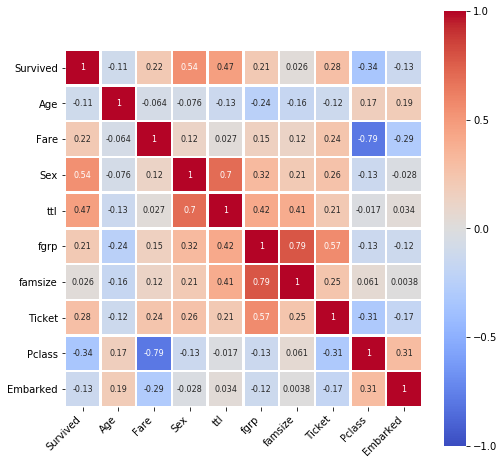

In [81]:
fig = plt.figure()
fig.set_size_inches(8, 8)
corr_matrix = data.drop(columns='PassengerId').corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1), data=corr_matrix, cmap='coolwarm')

#### Train base estimators for stacking model

In [82]:
X = data.drop(columns=['Survived', 'PassengerId'])
y = data['Survived']

In [83]:
#common random_state
random_state=30
#cross validation strategy
cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=random_state)
#cross validation metrics
scoring = {'balanced_accuracy': 'balanced_accuracy', 
           'roc_auc':  'roc_auc',
           'precision_macro': 'precision_macro'}
refit = 'roc_auc'

In [84]:
n = len(y)
class_priors = {}
class_weights = {}
for i in y.unique():
    class_priors[i] = len(y.loc[y==i]) / n
    class_weights[i] = 1- class_priors[i]

In [85]:
base_scores = {}

#### LinearDiscriminantAnalysis

In [88]:
lda = disan.LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
scores = cv_rep(lda, X, y, cv, scoring)
base_scores['lda'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.808775  0.869546         0.819865
std_train            0.013135  0.013891         0.012587
mean_test            0.792851  0.862792         0.808007
std_test             0.024264  0.023125         0.022538


In [89]:
base_scores['lda'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### QuadraticDiscriminantAnalysis

In [90]:
qda = disan.QuadraticDiscriminantAnalysis(priors=[class_priors[0], class_priors[1]], reg_param=0.08989795918367348)
scores = cv_rep(qda, X, y, cv, scoring)
base_scores['qda'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.809147  0.863105         0.811271
std_train            0.012868  0.012509         0.012799
mean_test            0.794872  0.849164         0.799620
std_test             0.025036  0.025143         0.028949


In [916]:
param_ranges = {'reg_param': np.linspace(0.001,0.1,99)}
qda, scores = train_best_model(qda, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.810073  0.859971         0.817108
std_train            0.008741  0.013245         0.009548
mean_test            0.792498  0.853195         0.801482
std_test             0.020096  0.025425         0.018406
{'reg_param': 0.09292857142857143}


In [91]:
base_scores['qda'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### AdaBoostClassifier

In [92]:
abc = ens.AdaBoostClassifier(algorithm='SAMME.R', 
                             learning_rate=0.07776923076923077,
                             n_estimators=65,
                             random_state=random_state)
scores = cv_rep(abc, X, y, cv, scoring)
base_scores['abc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.818144  0.877274         0.832255
std_train            0.010721  0.011017         0.010182
mean_test            0.802006  0.864978         0.819581
std_test             0.022569  0.023358         0.022312


In [918]:
param_ranges = {'n_estimators': np.arange(5, 100, 20), 'learning_rate': np.linspace(0.001, 0.5, 40)}
abc, scores = train_best_model(abc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.821128  0.889999         0.838062
std_train            0.012550  0.011414         0.015436
mean_test            0.803098  0.866337         0.821434
std_test             0.023386  0.021291         0.022570
{'learning_rate': 0.09056410256410256, 'n_estimators': 85}


In [93]:
base_scores['abc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### ExtraTreesClassifier

In [94]:
etc = ens.ExtraTreesClassifier(random_state=random_state, n_jobs=-1, criterion='entropy',
                               n_estimators=75,
                               max_depth=5,
                               ccp_alpha=0.0)
scores = cv_rep(etc, X, y, cv, scoring)
base_scores['etc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.824799  0.910165         0.843455
std_train            0.011227  0.009942         0.008565
mean_test            0.794784  0.870330         0.816315
std_test             0.024544  0.022119         0.022809


In [920]:
param_ranges = {'criterion': ['gini', 'entropy'], 
                'n_estimators': np.arange(60, 100, 5),
                'max_depth': np.arange(3, 10)}
etc, scores = train_best_model(etc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.836312  0.922787         0.886171
std_train            0.012006  0.007406         0.010424
mean_test            0.797758  0.874828         0.818034
std_test             0.024243  0.018590         0.027277
{'criterion': 'gini', 'max_depth': 6, 'n_estimators': 95}


In [921]:
param_ranges = {'ccp_alpha': np.linspace(0.001,0.01, 60)}
etc, scores = train_best_model(etc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.829342  0.913324         0.846771
std_train            0.010345  0.007920         0.008354
mean_test            0.800003  0.871259         0.819395
std_test             0.024620  0.020985         0.025026
{'ccp_alpha': 0.001}


In [95]:
base_scores['etc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### RandomForestClassifier

In [96]:
rfc = ens.RandomForestClassifier(random_state=random_state, n_jobs=-1, criterion='entropy',
                                 n_estimators=20,
                                 max_depth=5,
                                 ccp_alpha=0.04)
scores = cv_rep(rfc, X, y, cv, scoring)
base_scores['rfc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.809418  0.862586         0.819760
std_train            0.016471  0.017438         0.019010
mean_test            0.788729  0.843760         0.801917
std_test             0.022284  0.029901         0.023452


In [923]:
param_ranges = {'criterion': ['gini', 'entropy'], 
                'n_estimators': np.arange(5, 100, 10),
                'max_depth': np.arange(3, 10)}
rfc, scores = train_best_model(rfc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.808778  0.863144         0.831375
std_train            0.016266  0.014766         0.013733
mean_test            0.791153  0.850824         0.818181
std_test             0.020577  0.020424         0.023901
{'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 15}


In [924]:
param_ranges = {'ccp_alpha': np.linspace(0.001,0.1, 60)}
rfc, scores = train_best_model(rfc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.814274  0.886840         0.829080
std_train            0.012278  0.011053         0.012276
mean_test            0.792786  0.865375         0.811368
std_test             0.022826  0.022883         0.020560
{'ccp_alpha': 0.0026779661016949154}


In [97]:
base_scores['rfc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### LogisticRegression

In [98]:
lr = lm.LogisticRegression(class_weight=class_weights, random_state=random_state, n_jobs=-1,
                           penalty='l2',
                           solver='liblinear',
                           dual=False,
                           C=1.3122448979591839)
scores = cv_rep(lr, X, y, cv, scoring)
base_scores['lr'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.809976  0.872432         0.805098
std_train            0.015914  0.013052         0.016800
mean_test            0.799191  0.865652         0.797903
std_test             0.031246  0.023422         0.026337


In [943]:
param_ranges = {'C': np.linspace(0.01, 5, 99), 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
lr, scores = train_best_model(lr, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.805770  0.870090         0.801564
std_train            0.011801  0.013882         0.012084
mean_test            0.800100  0.866517         0.799149
std_test             0.029733  0.024017         0.025003
{'C': 0.926530612244898, 'solver': 'lbfgs'}


In [99]:
base_scores['lr'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### RidgeClassifier

In [100]:
rc = lm.RidgeClassifier(class_weight=class_weights, random_state=random_state,
                        alpha=11.122448979591837)
scores = cv_rep(rc, X, y, cv, scoring)
base_scores['rc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.809504  0.870001         0.813501
std_train            0.012067  0.013762         0.012322
mean_test            0.796322  0.863645         0.802799
std_test             0.024349  0.022013         0.020831


In [928]:
param_ranges = {'alpha': np.linspace(1, 45, 99)}
rc, scores = train_best_model(rc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.796588  0.868289         0.806309
std_train            0.012774  0.014233         0.013074
mean_test            0.797132  0.865552         0.799873
std_test             0.023162  0.024011         0.019406
{'alpha': 43.6530612244898}


In [101]:
base_scores['rc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### SVC

In [102]:
svc = svm.SVC(kernel='rbf', gamma='scale', shrinking=True, class_weight=class_weights,
              C=9428.57142857143)
scores = cv_rep(svc, X, y, cv, scoring)
base_scores['svc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.833521  0.898703         0.840091
std_train            0.015848  0.013006         0.016400
mean_test            0.786193  0.835525         0.794718
std_test             0.023483  0.032429         0.025215


In [942]:
param_ranges = {'C': np.linspace(400, 1000, 23)}
svc, scores = train_best_model(svc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.811978  0.867740         0.812407
std_train            0.013215  0.014424         0.013256
mean_test            0.804957  0.860633         0.806403
std_test             0.021197  0.024536         0.025326
{'C': 754.5454545454545}


In [103]:
base_scores['svc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

In [104]:
nusvc = svm.NuSVC(kernel='rbf', gamma='scale', shrinking=True, class_weight=class_weights,
                 nu=0.5102089795918366)
scores = cv_rep(nusvc, X, y, cv, scoring)
base_scores['nusvc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.814278  0.855467         0.828099
std_train            0.010601  0.012062         0.010780
mean_test            0.791818  0.832642         0.809321
std_test             0.020462  0.016069         0.021850


In [932]:
param_ranges = {'nu': np.linspace(0.1,0.5,99)}
nusvc, scores = train_best_model(nusvc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.812216  0.866157         0.832915
std_train            0.023854  0.012700         0.014336
mean_test            0.794357  0.846693         0.819401
std_test             0.020614  0.022323         0.026112
{'nu': 0.4877551020408164}


In [105]:
base_scores['nusvc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### Base estimators scores

In [107]:
pd.DataFrame(base_scores, index=['test_score', 'train_score']).sort_values(by='test_score', axis=1,ascending=False)

,etc,lr,abc,rc,lda,qda,rfc,svc,nusvc
test_score,0.870330,0.865652,0.864978,0.863645,0.862792,0.849164,0.843760,0.835525,0.832642
train_score,0.910165,0.872432,0.877274,0.870001,0.869546,0.863105,0.862586,0.898703,0.855467


In [108]:
base_models_surv_dic = {'lda':lda,'qda':qda,'abc':abc,'etc':etc,'rfc':rfc,'lr':lr,'rc':rc,'svc':svc,'nusvc':nusvc}

In [109]:
base_models_surv = [(k,base_models_surv_dic[k]) for k in base_models_surv_dic.keys()]

c:\00_data\python38\lib\site-packages\sklearn\linear_model\_logistic.py:1537: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


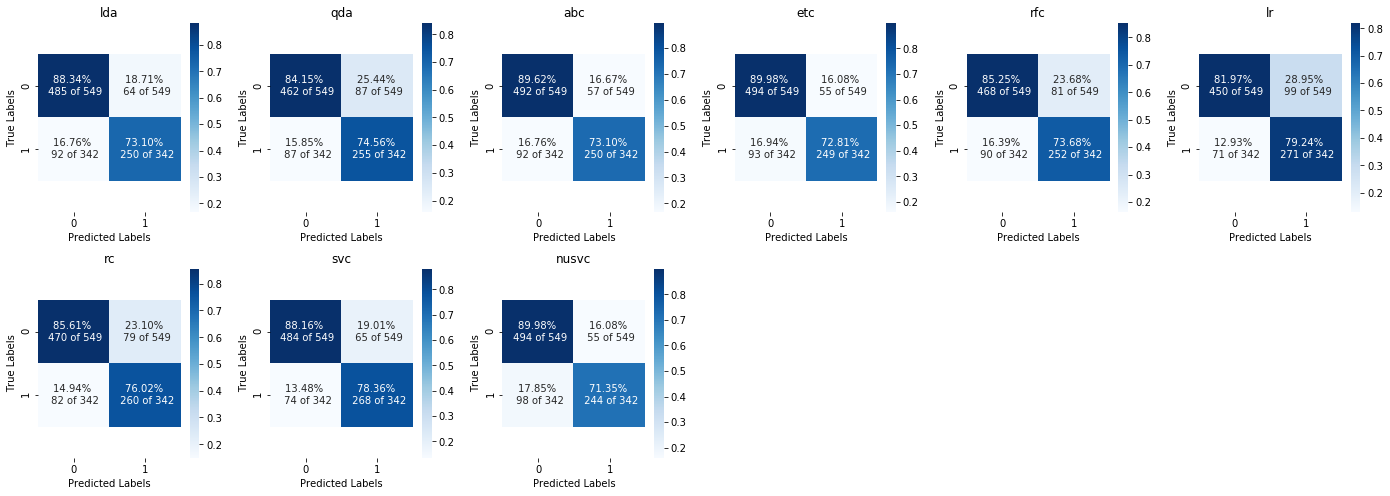

In [110]:
grd_n = len(base_models_surv)
grd_cols_n = 6
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))
fig = plt.figure()
fig.set_size_inches(4 * grd_cols_n, 4 * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.3)

for i, m in enumerate(base_models_surv):
    lbl, model = m
    plot_confusion_matrix(model, X, y, ax=fig.add_subplot(gs[i]), normalize=True, title=lbl)

In [111]:
def base_models_predictions(models, X):
    X1 = None
    for i, model in models:
        if X1 is None:
            X1 = pd.Series(model.predict(X), name=i).to_frame()
        else:
            X1 = X1.merge(pd.Series(model.predict(X), name=i).to_frame(), left_index=True, right_index=True)
    return X1

In [112]:
def base_models_predictions_proba(models, X):
    X0 = None
    X1 = None
    for i, model in models:
        proba_0 = model.predict_proba(X)[:,0]
        proba_1 = model.predict_proba(X)[:,1]
        if X0 is None:
            X0 = pd.Series(proba_0, name='{0}_proba'.format(i)).to_frame()
        else:
            X0 = X0.merge(pd.Series(proba_0, name='{0}_proba'.format(i)).to_frame(), left_index=True, right_index=True)
        
        if X1 is None:
            X1 = pd.Series(proba_1, name='{0}_proba'.format(i)).to_frame()
        else:
            X1 = X1.merge(pd.Series(proba_1, name='{0}_proba'.format(i)).to_frame(), left_index=True, right_index=True)
    return (X0, X1)

#### Base estimators correlation matrix

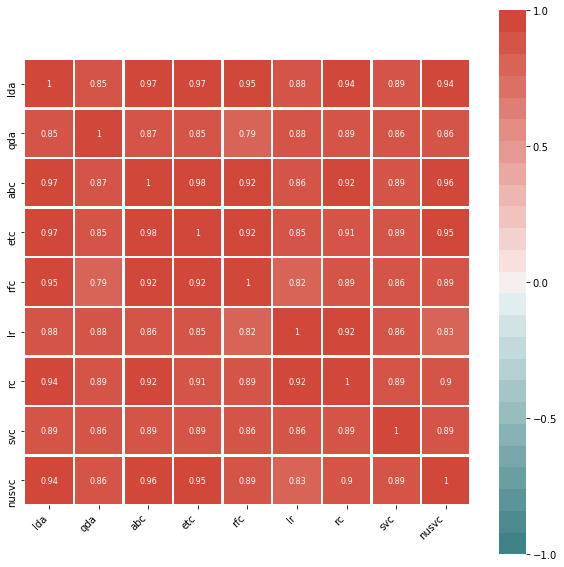

In [113]:
preds_base = base_models_predictions(base_models_surv, X)
fig = plt.figure()
fig.set_size_inches(10, 10)
corr_matrix = preds_base.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1),
                              data=corr_matrix,
                             cmap=sns.diverging_palette(200, 15, s=75, l=50, sep=1, n=25, center='light', as_cmap=False))

In [114]:
# Mean of each model correlation coefficients
corr_sc = {}
for k in base_models_surv_dic.keys():
    corr_sc[k] = (corr_matrix[k].sum() - 1) / len(corr_matrix.index)
df_base_models_corr_sc = pd.DataFrame(corr_sc, index=['cc'])
df_base_models_corr_sc.sort_values(by='cc', axis=1, ascending=False)

,lda,abc,etc,rc,nusvc,rfc,svc,lr,qda
cc,0.820399,0.818386,0.813985,0.805765,0.801585,0.781501,0.780082,0.765337,0.760414


#### Select less correlated models

In [115]:
base_models_surv_dic = {'lda':lda,'qda':qda,'abc':abc,'etc':etc,'rc':rc,'svc':svc}

In [116]:
base_models_surv = [(k,base_models_surv_dic[k]) for k in base_models_surv_dic.keys()]

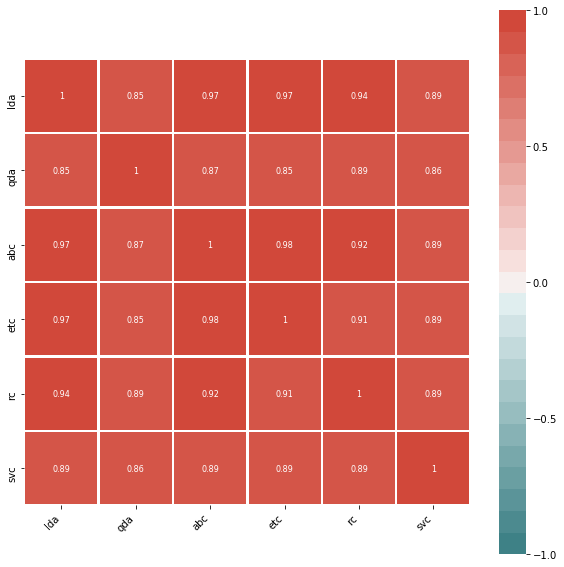

In [117]:
preds_base = base_models_predictions(base_models_surv, X)
fig = plt.figure()
fig.set_size_inches(10, 10)
corr_matrix = preds_base.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1),
                              data=corr_matrix,
                             cmap=sns.diverging_palette(200, 15, s=75, l=50, sep=1, n=25, center='light', as_cmap=False))

In [118]:
# Mean of each model correlation coefficients
corr_sc = {}
for k in base_models_surv_dic.keys():
    corr_sc[k] = (corr_matrix[k].sum() - 1) / len(corr_matrix.index)
df_base_models_corr_sc = pd.DataFrame(corr_sc, index=['cc'])
df_base_models_corr_sc.sort_values(by='cc', axis=1, ascending=False)

,abc,lda,etc,rc,svc,qda
cc,0.771803,0.76992,0.767916,0.758141,0.735652,0.719811


#### Compare stacking classifier score for different final estimator models

In [119]:
def train_final_models(models, X, y, score, cv_folds=5):
    scores = {}
    fin_models = []
    for m in models:
        model_st = ens.StackingClassifier(estimators=base_models_surv,
                                          final_estimator=m[1],
                                          cv=cv_folds, 
                                          stack_method='predict', 
                                          n_jobs=-1)
        res = cv_rep(model_st, X, y, cv, scoring)
        scores[m[0]] = [res.loc['mean_test', score], res.loc['mean_train', score]]
        fin_models.append((m[0], model_st))
    scores = pd.DataFrame(scores, index=['Test_score', 'Train_score']).sort_values(by='Test_score', axis=1,ascending=False)
    return fin_models, scores

In [120]:
final_models_surv = [('abc', ens.AdaBoostClassifier()),
                     ('etc', ens.ExtraTreesClassifier()),
                     ('rfc', ens.RandomForestClassifier()),
                     ('lr', lm.LogisticRegression()),
                     ('svc', svm.SVC())]

In [121]:
fin_models, scores = train_final_models(final_models_surv, X, y, cv_folds=5, score=refit)

In [122]:
scores

,abc,lr,rfc,etc,svc
Test_score,0.821386,0.819826,0.813004,0.811430,0.806481
Train_score,0.843071,0.841409,0.839062,0.837865,0.835925


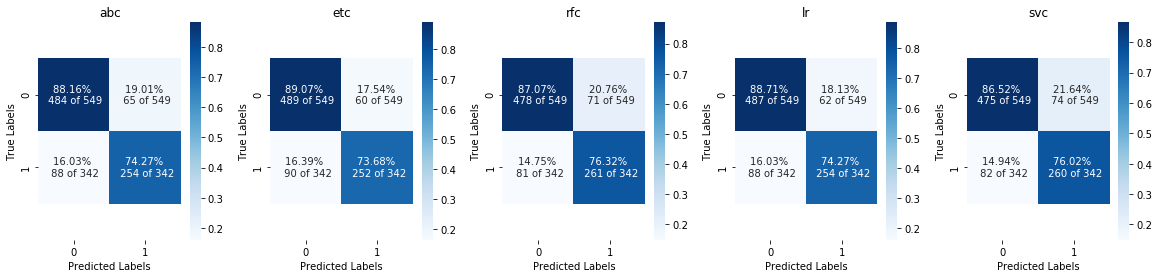

In [871]:
grd_n = len(fin_models)
grd_cols_n = 6
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))
fig = plt.figure()
fig.set_size_inches(4 * grd_cols_n, 4 * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.3)

for i, m in enumerate(fin_models):
    lbl, model = m
    plot_confusion_matrix(model, X, y, ax=fig.add_subplot(gs[i]), normalize=True, title=lbl)

#### Train stacking classifier

In [123]:
model_st = ens.StackingClassifier(estimators=base_models_surv,
                                  final_estimator=ens.AdaBoostClassifier(algorithm='SAMME.R', 
                                                                         learning_rate=0.6,
                                                                         n_estimators=80,
                                                                         random_state=random_state),
                                  cv=5, 
                                  stack_method='predict', 
                                  passthrough=False,
                                  n_jobs=-1)

cv_rep(model_st, X, y, cv, scoring)

,balanced_accuracy,roc_auc,precision_macro
mean_train,0.820544,0.842830,0.836631
std_train,0.009007,0.018178,0.008028
mean_test,0.801642,0.821306,0.820019
std_test,0.025702,0.024444,0.024183


In [970]:
param_ranges = {'final_estimator__n_estimators': np.arange(50, 120, 10), 'final_estimator__learning_rate': np.linspace(0.1, 0.8, 20)}
model_st, scores = train_best_model(model_st, param_ranges, X, y, scoring, cv, refit=refit)


            balanced_accuracy   roc_auc  precision_macro
mean_train           0.820704  0.841414         0.836018
std_train            0.013033  0.011235         0.013725
mean_test            0.798732  0.820691         0.818308
std_test             0.023739  0.030667         0.021704
{'final_estimator__learning_rate': 0.1, 'final_estimator__n_estimators': 50}


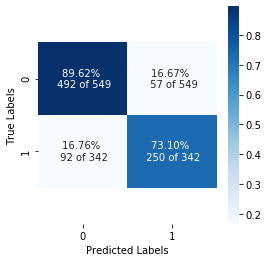

In [124]:
fig = plt.figure()
fig.set_size_inches(4,4)
plot_confusion_matrix(model_st, X, y, ax=fig.add_subplot(1,1,1), normalize=True, title='')

## Predict test set

#### Preprocessind data

In [125]:
data = family_groups_encoder(data_test.copy(), fgrp_mask)
data = fare_encoder(data, fare_mask)
data = fare_transformer(data)

data = ticket_encoder(data, ticket_mask)

data = title_encoder(data)
data = sex_encoder(data)
data = fam_size(data)

data = embarked_encoder(data)
data = pclass_encoder(data)

data = age_predictor(data, age_cls_model, age_reg_mogel)
data = data[['PassengerId', 'Age', 'Fare', 'Sex', 'ttl', 'fgrp', 'famsize', 'Ticket', 'Pclass', 'Embarked']]

#### Make predictions

In [985]:
X = data.drop(columns=['PassengerId'])

In [986]:
data['Survived'] = model_st.predict(X)
df_submission = data[['PassengerId', 'Survived']]
df_submission.to_csv("df_submission.csv", index=False)